<a href="https://colab.research.google.com/github/insaiyancvk/Dere-Net/blob/main/Dere_Net_dirty_work_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. See what data we got

## Plot sample data


In [ ]:
#@title
path = "./waifus/waifus_images/waifus_images_train/Dandere/Kosaki Onodera40.png"
w = cv2.imread(path, 3)
RGB_img = cv2.cvtColor(w, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [ ]:
#@title
RGB_img.shape, type(RGB_img)

((300, 168, 3), numpy.ndarray)

In [ ]:
#@title
TRAIN_PATH

'waifus\\waifus_images\\waifus_images_train'

In [ ]:
#@title
## Print out images
fig, axs = plt.subplots(7,5, figsize=(15,15), constrained_layout=True)
fig = plt.figure(figsize=(10,3))

for ax, row in zip(axs[:,0], class_list):
    ax.set_ylabel(row, rotation=90, fontsize=26)

a, b = 0, 0
for i in os.listdir(TRAIN_PATH):
    imgs = os.listdir(os.path.join(TRAIN_PATH, i))
    random.shuffle(imgs)
    for j in imgs:
        img2 = cv2.imread(os.path.join(TRAIN_PATH, i, j))
        try:
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        except:
            print(os.path.join(TRAIN_PATH, i, j))
            continue
        rm = axs[a][b].imshow(img2)
        plt.axis('off')
        rm.axes.get_xaxis().set_visible(False)
#         rm.axes.get_yaxis().set_visible(False)
        b+=1
        if b>4:
            b=0
            break
    a+=1
    if a>6:
        break

**NOTE:** Use image size: 224,224 or 256,256 ~(since we ain't got chad GPUs)~ we do 😏


## Import stuff

In [31]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, random

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# from tqdm import tnrange,tqdm_notebook, tqdm
# from functools import partial
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocess the data

In [ ]:
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && mkdir /content/waifus && cp /content/drive/MyDrive/kaggle/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading the dataset")
!kaggle datasets download jahelsantiagoleon/female-anime-characters-anime-dataset 
print("Extracting the dataset")
!unzip -q female-anime-characters-anime-dataset.zip -d /content/waifus/

print("Initializing classes")

class_list = [
    'dandere',
    'deredere',
    'himdere',
    'kundere',
    'tsundere',
    'yandere',
    'yangire'
]

print("Creating folders for workspace")
FOLDERS = {
    "WAIFUS": os.path.join("waifus"),
    # "PROCESSED": os.path.join("waifus","waifus_images"),
    "TRAIN": os.path.join("waifus","waifus_images","waifus_images_train"),
    "TEST": os.path.join("waifus","waifus_images","waifus_images_val"),
    "WORKSPACE": os.path.join("waifus","Workspace"),
    "MODELS" : os.path.join("waifus","Workspace","Models"),
    "LOSS" : os.path.join("waifus","Workspace","Loss"),
    "ACCURACY" : os.path.join("waifus","Workspace","Accuracy"),
    "LOSS_TRAIN" : os.path.join("waifus","Workspace","Loss","Train"),
    "LOSS_TEST" : os.path.join("waifus","Workspace","Loss","Test"),
    "ACCURACY_TRAIN" : os.path.join("waifus","Workspace","Accuracy","Train"),
    "ACCURACY_TEST" :os.path.join("waifus","Workspace","Accuracy","Test")
}

for key in FOLDERS:
    if not os.path.isdir("./"+FOLDERS[key]):
        print(key," directory doesn't exist. Creating one.")
        os.mkdir("./"+FOLDERS[key])
        print(key, " directory created.")
    else:
        print(key, "exists")

print("Transforming the waifu data")
transformations = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transformations_test = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
#     def __getitem__(self, index):
#         original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
#         path = self.imgs[index][0]
#         tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path

# train_dataset = ImageFolderWithPaths(root="./dataset/waifus/waifus_images/waifus_images_train/", transform = transformations)
print("Creating train dataloader")
train_dataset = datasets.ImageFolder(FOLDERS["TRAIN"], transform = transformations)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)

# test_dataset = torchvision.datasets.ImageFolder(FOLDERS["TEST"], transform=transformations_test)
print("Creating test dataloader")
test_dataset = datasets.ImageFolder(FOLDERS["TEST"], transform = transformations)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,
                                         shuffle=True)

print("Data preprocessing completed.")

## The Model:

In [5]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(5, 5)
        
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 3)
        
        self.fc1 = nn.Linear(16, 7)
        #self.fc2 = nn.Linear(500, 50)
        #self.fc3 = nn.Linear(50, 7)

    def forward(self, x):
        
        # Conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        #print("Tensor shape: ",x.shape)
        
        # Flatten the batch
        x = x.view(x.size(0),-1)
        #print(x.shape)
        
        # Dense layer 1
        x = self.fc1(x)
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x

In [5]:
#@title
net =  Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)
items = iter(train_loader)

In [ ]:
#@title
# Testing if all the parameters of the NN are set properly

image, label, p = items.next()
x = net(image[0].unsqueeze(0))
# print(x.shape)
f = plt.imshow(np.transpose(image[0], (1,2,0)));
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
plt.title(
    "Name: "+''.join([i for i in os.path.splitext(os.path.basename(p[0]))[0] if not i.isdigit()])+"\n"+
    "Predicted: "+class_list[x.cpu().data.numpy().argmax()]+"\n"+"Actual: "+class_list[label[0].item()+1],
    loc='center'
);

## Steps
- pass imgae to the NN
- calculate loss
- backprop
- update weights

In [6]:
#@title
def train_step(model, images, labels, loss_func, optim, device):
    
    # Set the gradiant values to zero because torch accumulates the values
    optim.zero_grad()
    
    # Predictions from the model
    outputs = model(images.to(device))
    
    # Calculate the loss
    loss = loss_func(outputs, labels.to(device))
    
    # Finds the derivative by applying chain rule
    loss.backward()
    
    # Move the loss function towards the local/global minima
    optim.step()
    
    # return the outputs and loss by moving them to CPU
    return outputs.cpu().detach().numpy(), loss.cpu().item()

In [7]:
#@title
def epoch(model, train_loader, loss_func, optim, device):
    mean_loss = 0
    model = model.to(device)
    for image, label in tqdm(train_loader):
        loss = train_step(model, image, label, loss_func, optim, device)
        mean_loss += loss/len(train_loader)
    return mean_loss

5. Build a training loop
    1. Move to GPU
    2. Define the training function
    3. Calculate the running loss and store the same in list and later convert to np array and save the np array.
    4. Calculate the accuracy after every batch. Calculate the average of same and store the values in a list 
       and later convert it to np array and save theh np array.
    5. After every epoch, test the model loss and accuracy 
       (by following the same steps as done for training ie, move to list, convert to np array, save the np array) with the test data.


In [40]:
def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  #  train_loss_vals = []
  #  train_accuracy_vals = []
   test_loss_vals = []
   test_accuracy_vals = []

   train_batch_loss = 0
   train_batch_accuracy = 0

   model = model.to(device)

   print("\n\t\tTraining the Neural Network... \n")
   
   train_metrics = tqdm(total=len(train_loader), position=1, bar_format='{desc}', leave=True)
   test_metrics = tqdm(total=len(test_loader), position=3, bar_format='{desc}')

   with tqdm(len(train_loader), position=0, leave=True) as pbar:
    for image, label in tnrange(train_loader, ncols=100, position=0, leave=True):

        optim.zero_grad()
        
        output = model(image.to(device))
        
        loss = loss_func(
          output,
          label.to(device)
          )
        
        loss.backward()
        optim.step()

        accuracy = np.average(
              np.argmax(
                output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
          )

        # train_loss_vals.append(loss.cpu().item()) # training loss for graph
        train_batch_loss += loss/len(train_loader) # training average loss
        # train_accuracy_vals.append(accuracy) # training accuray for graph
        train_batch_accuracy += accuracy/len(train_loader) # training average accuracy
        train_metrics.write(f"Loss: {train_batch_loss:.2f}  Accuracy: {train_batch_accuracy:.2f}")
        train_metrics.update()
        pbar.update()
   
   print("\n\t\tValidating Neural Network... \n")

   with tqdm(len(test_loader), position=2, leave=True) as pbar:
    for image, label in trange(len(test_loader), ncols=100, position=0, leave=True):

        output = model(image.to(device))

        loss = loss_func(
          output,
          label.to(device)
        )

        accuracy = np.average(
          np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
          )

        test_loss_vals.append(loss.cpu().item()) # testing loss for graph
        test_accuracy_vals.append(accuracy) # testing accuracy for graph
        test_metrics.set_description_str(f"Test loss: {(sum(test_loss_vals)/len(test_loss_vals)):.2f}\n{(sum(test_accuracy_vals)/len(test_accuracy_vals)):.2f}")

        pbar.update()

   return (

      # TRAIN LOSS
      # train_loss_vals, # list 0
      train_batch_loss, # float 1

      # TRAIN ACCURACY
      # train_accuracy_vals, # list 2
      train_batch_accuracy, # float 3

      # TEST LOSS, ACCURACY
      sum(test_loss_vals)/len(test_loss_vals), # list 4
      sum(test_accuracy_vals)/len(test_accuracy_vals) # list 5
   )

In [ ]:
vals = epoch(net, test_loader ,train_loader, loss_func, optimizer, device)

In [6]:
net =  Net()
net = net.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

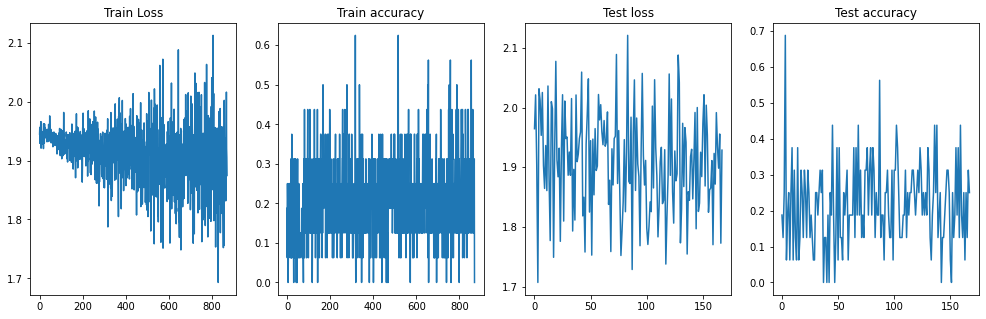

In [28]:
fig, a = plt.subplots(1,4, squeeze=False, figsize=(17,5))
a[0][0].plot(vals[0])
a[0][0].set_title("Train Loss")
a[0][1].plot(vals[2])
a[0][1].set_title("Train accuracy")
a[0][2].plot(vals[4])
a[0][2].set_title("Test loss")
a[0][3].plot(vals[5])
a[0][3].set_title("Test accuracy")
plt.show()

In [ ]:
EPOCH = 1
PATH = "./dataset/waifus/models/"
MODEL1 = "3conv_3RLU_3MP2d_1d_crossentropy_sgd.pt"
LOSS = 1.9

In [ ]:
# Save the model
torch.save({
    'epoch': EPOCH,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': LOSS
}, 
    PATH+MODEL1)

In [ ]:
# Load the saved model
checkpoint = torch.load(PATH+MODEL1)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])